In [111]:
import PlayData
import pandas as pd
import numpy as np
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from pylab import plot,show,hist,figure,title,savefig,rcParams
rcParams['figure.figsize'] = (15, 10)

In [112]:
database = "playstoreX.db"
appid = "com.oxbowsoft.debtplanner"


displayer = PlayData.PlayData(database)
title = displayer.getTitle(appid)
(date,rank) = displayer.getRankLatest(appid, 'FINANCE', 'topselling_free')
print "The app %s is ranked %s on %s" % (title, rank, date)
ranking_json = displayer.getRank(appid, 'FINANCE', 'topselling_free')
#all_ranking_json = displayer.getAllRanks('FINANCE', 'topselling_free')
all_ranking_json = displayer.getAllRanks('FINANCE', 'topselling_paid')
#print ranking_json

The app Debt Payoff Planner is ranked 165 on 2016-03-10


In [113]:
all_ranking_data = pd.read_json(all_ranking_json)

all_ranking_data = all_ranking_data.rename(columns = {1:'Date'})
all_ranking_data['Date'] = all_ranking_data['Date'].apply(pd.to_datetime)
#all_ranking_data = all_ranking_data.set_index('Date')
all_ranking_data = all_ranking_data.rename(columns = {0:'AppId'})
all_ranking_data = all_ranking_data.rename(columns = {2:'Rank'})
all_ranking_data=all_ranking_data.pivot(index='Date', columns='AppId', values='Rank')
all_ranking_data = all_ranking_data
print all_ranking_data.index
#print all_ranking_data

KeyError: 'Date'

(17, 530)
(17, 15)


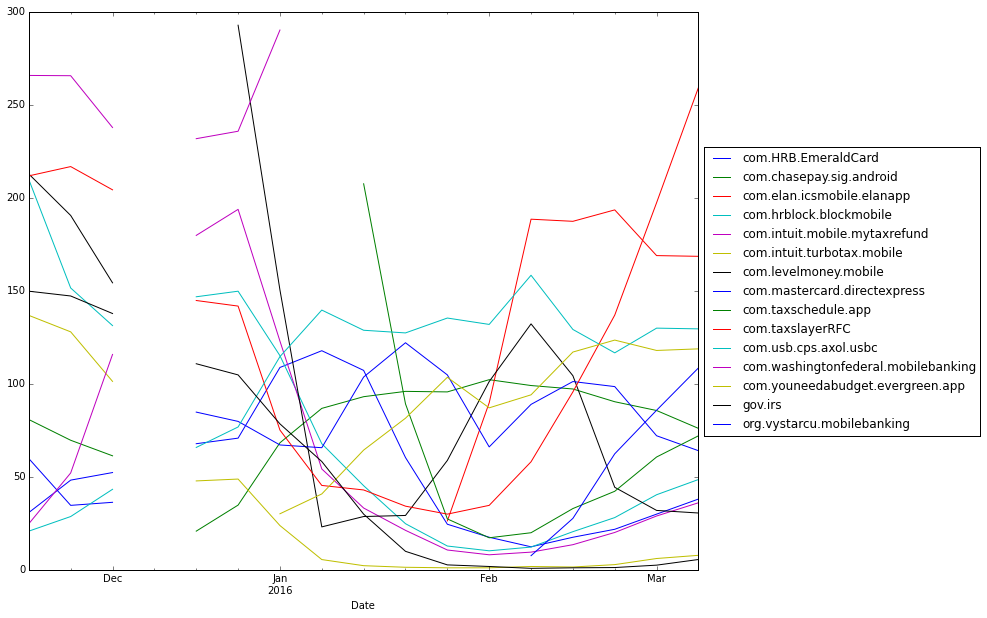

In [109]:
all_ranking_data_average_week = all_ranking_data.resample('w', 'mean')
print all_ranking_data_average_week.shape
all_ranking_data_average_week = all_ranking_data_average_week.ix[:,all_ranking_data_average_week.max()>100]
all_ranking_data_average_week = all_ranking_data_average_week.ix[:,all_ranking_data_average_week.min()<40]
print all_ranking_data_average_week.shape


all_ranking_data_average_week.plot()
ax = plt.gca()

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.draw()


In [72]:

ranking_data = pd.read_json(ranking_json)
ranking_data = ranking_data.rename(columns = {0:'Date'})
ranking_data = ranking_data.rename(columns = {1:appid})
ranking_data['Date'] = ranking_data['Date'].apply(pd.to_datetime)
print type(ranking_data['Date'])
ranking_data = ranking_data.set_index('Date')

<class 'pandas.core.series.Series'>


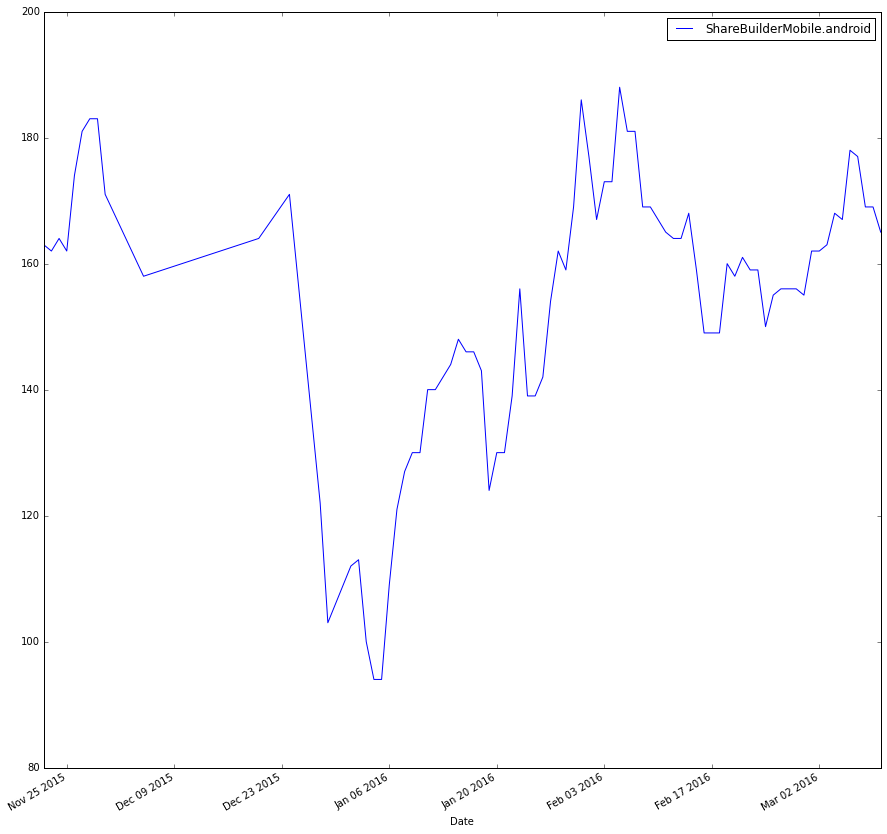

In [73]:
ranking_Data = ranking_data.resample('w', 'sum')
ranking_data.plot()
savefig(appid+'.png')

In [ ]:
title = displayer.sendEmail(appid)